In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

## True distribution

Text(0.5, 1.0, 'PDF of true gaussian distribution')

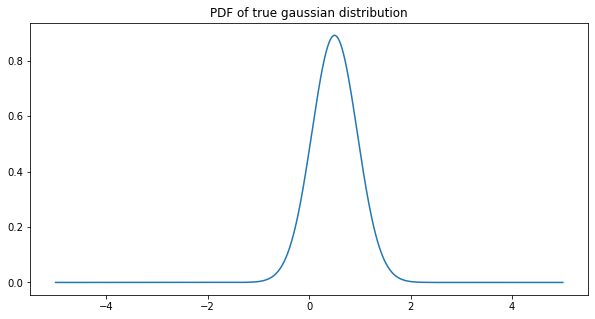

In [6]:
true_mu = 0.5
true_lambda = 5.0

x_lin = np.linspace(-5.0, 5.0, 1000)
pdf = norm.pdf(x_lin, loc=true_mu, scale=true_lambda**-0.5)

fig = plt.figure(figsize=(10, 5))
fig.set_facecolor('white')
plt.plot(x_lin, pdf)
plt.title('PDF of true gaussian distribution')

In [14]:
n_samples = 10
x_samples = np.random.randn(n_samples)*(true_lambda**-0.5) + true_mu

Text(0, 0.5, 'Dummy axis')

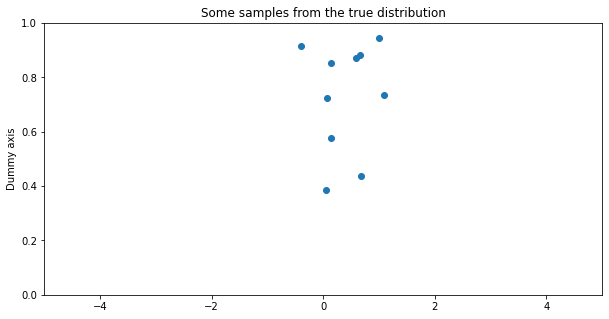

In [16]:
fig = plt.figure(figsize=(10, 5))
fig.set_facecolor('white')

plt.scatter(x_samples, np.random.rand(n_samples))
plt.axis([-5, 5, 0, 1])
plt.title('Some samples from the true distribution')
plt.ylabel('Dummy axis')

## Prior distribution

In [94]:
mu_0 = 0
k_0 = 0.05
a_0 = 2.0
b_0 = 0.3

def prior(mu, l):
    normal_term = norm.pdf(mu, loc=mu_0, scale=(k_0 * l)**-0.5)    
    gamma_term = gamma.pdf(l, a=a_0, scale=1/b_0)
    prob = normal_term * gamma_term
    return prob

mu_lin = np.linspace(-5, 5, 80)
l_lin = np.linspace(0.001, 10, 100)

mu_mesh, l_mesh = np.meshgrid(mu_lin, l_lin)
prior_lhood = np.empty((len(l_lin), len(mu_lin)))

for i in range(len(l_lin)):
    for j in range(len(mu_lin)):
        prior_lhood[i, j] = prior(mu_mesh[i, j], l_mesh[i, j])

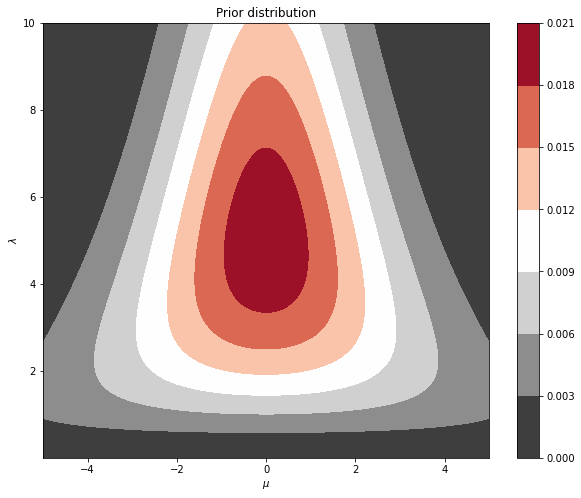

In [86]:
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')
plt.contourf(mu_mesh, l_mesh, prior_lhood, cmap='RdGy_r')
plt.xlabel('$\mu$')
plt.ylabel('$\lambda$')
plt.title('Prior distribution')
plt.colorbar()

## Data log-likelihood 

In [87]:
def data_loglhood(samples, mu, l):
    log_lhood = 0.0
    for s in samples:
        log_lhood += norm.logpdf(s, loc=mu, scale=l**-0.5)
    return log_lhood

In [88]:
mu_lin = np.linspace(-1, 1, 80)
l_lin = np.linspace(0.001, 10, 100)

mu_mesh, l_mesh = np.meshgrid(mu_lin, l_lin)
data_loglhood_mesh = np.empty((len(l_lin), len(mu_lin)))

for i in range(len(l_lin)):
    for j in range(len(mu_lin)):
        data_loglhood_mesh[i, j] = data_loglhood(x_samples, mu_mesh[i, j], l_mesh[i, j])

### Maximum likelihood estimation

In [89]:
max_lhood_mu = np.mean(x_samples)
max_lhood_l = np.std(x_samples)**-2
print(f'Maximum likelihood estimation of mu: {max_lhood_mu:.2f}')
print(f'Maximum likelihood estimation of lambda: {max_lhood_l:.2f}')

Maximum likelihood estimation of mu: 0.40
Maximum likelihood estimation of lambda: 4.89


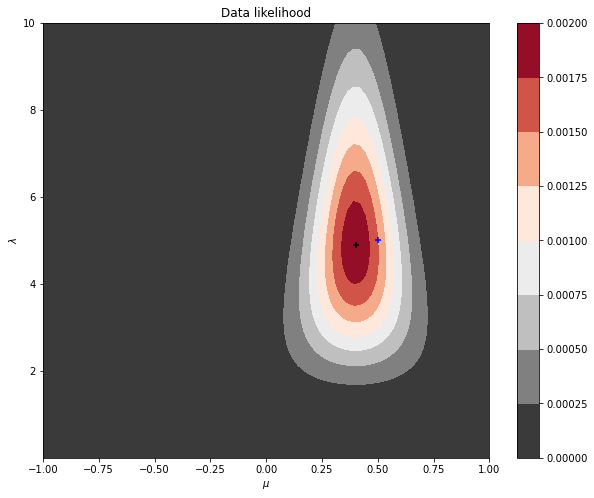

In [90]:
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')
plt.contourf(mu_mesh, l_mesh, np.exp(data_loglhood_mesh), cmap='RdGy_r')
plt.xlabel('$\mu$')
plt.ylabel('$\lambda$')
plt.title('Data likelihood')
plt.colorbar()

plt.scatter(max_lhood_mu, max_lhood_l, marker='+', c='k')
plt.scatter(true_mu, true_lambda, marker='+', c='b')

## Unnormalized log posterior

In [91]:
def unnorm_log_posterior(samples, mu, l):
    return np.log(prior(mu, l)) + data_loglhood(samples, mu, l)

In [106]:
mu_lin = np.linspace(-1, 1, 80)
l_lin = np.linspace(0.001, 10, 100)

mu_mesh, l_mesh = np.meshgrid(mu_lin, l_lin)
unnorm_posterior_mesh = np.empty((len(l_lin), len(mu_lin)))

for i in range(len(l_lin)):
    for j in range(len(mu_lin)):
        unnorm_posterior_mesh[i, j] = unnorm_log_posterior(
            x_samples, mu_mesh[i, j], l_mesh[i, j])

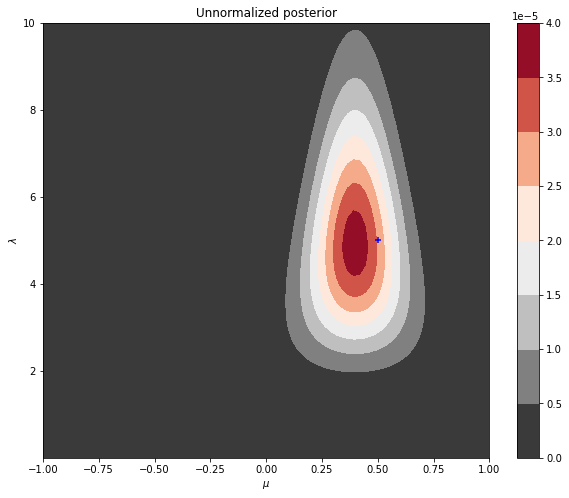

In [118]:
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')
plt.contourf(mu_mesh, l_mesh, np.exp(unnorm_posterior_mesh), cmap='RdGy_r')
plt.xlabel('$\mu$')
plt.ylabel('$\lambda$')
plt.title('Unnormalized posterior')
plt.colorbar()

plt.scatter(true_mu, true_lambda, marker='+', c='b')

## Variational Bayes

$$q_{\mu}(\mu) = \mathcal{N}(\mu | \mu_N, \kappa_{N}^{-1})$$
$$q_{\lambda}(\lambda) = \text{Ga}(\lambda | a_N, b_N)$$

In [114]:
mu_N = (k_0*mu_0 + n_samples*np.mean(x_samples)) / (k_0 + n_samples)
a_N = a_0 + (n_samples+1)/2

k_N = (k_0+n_samples)*a_N/b_0
expect_mu_sq_N = 1/k_N + mu_N**2

sum_term = 0.0
for s in x_samples:
    sum_term += s**2 + expect_mu_sq_N - 2*mu_N*s

b_N = b_0 + k_0*(expect_mu_sq_N + mu_0**2 -2*mu_N*mu_0) + 0.5*sum_term

for i in range(5):
    k_N = (k_0+n_samples)*a_N/b_N
    expect_mu_sq_N = 1/k_N + mu_N**2

    sum_term = 0.0
    for s in x_samples:
        sum_term += s**2 + expect_mu_sq_N - 2*mu_N*s

    b_N = b_0 + k_0*(expect_mu_sq_N + mu_0**2 -2*mu_N*mu_0) + 0.5*sum_term
    

In [108]:
def approx_factored_log_posterior(mu, l, mu_N, k_N, a_N, b_N):
    normal_term = norm.logpdf(mu, loc=mu_N, scale=(k_N)**-0.5)    
    gamma_term = gamma.logpdf(l, a=a_N, scale=1/b_N)
    log_prob = normal_term + gamma_term
    return log_prob

In [115]:
mu_lin = np.linspace(-1, 1, 80)
l_lin = np.linspace(0.001, 10, 100)

mu_mesh, l_mesh = np.meshgrid(mu_lin, l_lin)
approx_posterior_mesh = np.empty((len(l_lin), len(mu_lin)))

for i in range(len(l_lin)):
    for j in range(len(mu_lin)):
        approx_posterior_mesh[i, j] = approx_factored_log_posterior(
            mu_mesh[i, j], l_mesh[i, j], mu_N, k_N, a_N, b_N)

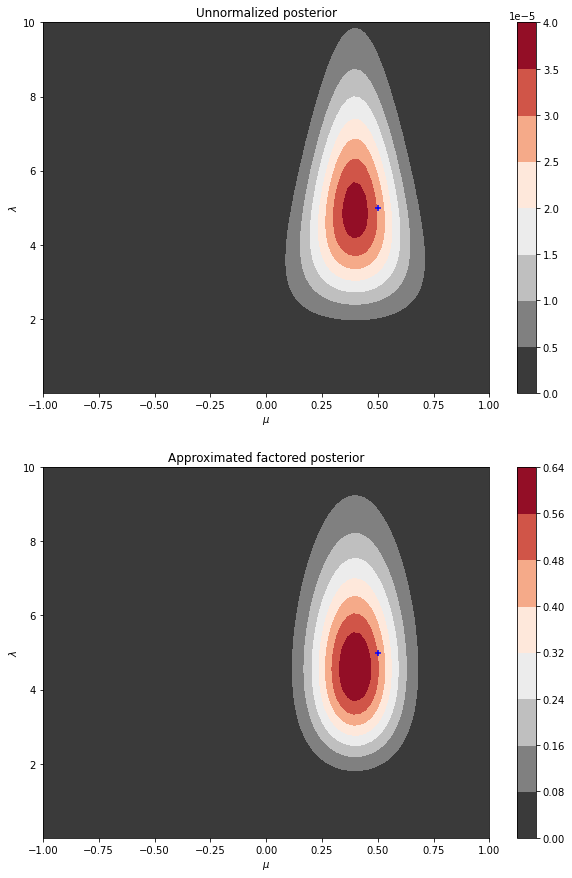

In [119]:
fig = plt.figure(figsize=(10, 15))
fig.set_facecolor('white')

plt.subplot(2, 1, 1)
plt.contourf(mu_mesh, l_mesh, np.exp(unnorm_posterior_mesh), cmap='RdGy_r')
plt.xlabel('$\mu$')
plt.ylabel('$\lambda$')
plt.title('Unnormalized posterior')
plt.colorbar()

plt.scatter(true_mu, true_lambda, marker='+', c='b')

plt.subplot(2, 1, 2)
plt.contourf(mu_mesh, l_mesh, np.exp(approx_posterior_mesh), cmap='RdGy_r')
plt.xlabel('$\mu$')
plt.ylabel('$\lambda$')
plt.title('Approximated factored posterior')
plt.colorbar()
plt.scatter(true_mu, true_lambda, marker='+', c='b')